In [1]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

In [2]:
#  Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    return movie

In [11]:
# 1 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load():
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv('/Users/apple/Desktop/Analysis_Projects/Movies-ETL/movies_metadata.csv', low_memory=False)
    ratings = pd.read_csv('/Users/apple/Desktop/Analysis_Projects/Movies-ETL/ratings.csv')    

    # Open and read the Wikipedia data JSON file.
    with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
        wiki_movies_raw = json.load(file)
        wiki_movies_df = pd.DataFrame(wiki_movies_raw)
    
    # Write a list comprehension to filter out TV shows.
    wiki_tv = [tvshows for tvshows in wiki_movies_raw
              if 'Television series' in tvshows]

    # Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    clean_movies = [clean_movie(movie) for movie in wiki_movies_raw]

    # Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(clean_movies)

    # Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    try:
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
    except: 
        print("No link to extract")
        
    #  Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
    wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

    # Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df['Box office'].dropna()
    
    # Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office[box_office.map(lambda x: type(x) != str)]

    # Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'

    # Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

    # Add the parse_dollars function.
    
    def parse_dollars(s):
    # if s is not a string, return NaN
      if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
      if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
      elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
      elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
      else:
        return np.nan
        
    # Clean the box office column in the wiki_movies_df DataFrame.
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)    
    wiki_movies_df.drop('Box office', axis=1, inplace=True)
    
    # Clean the budget column in the wiki_movies_df DataFrame.
    budget = wiki_movies_df['Budget'].dropna()
    
    
    # Convert any list to strings
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    
    # Remove any values between a dollar sign and a hyphen
    # (for budgets given in range):
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    
    # Use the same pattern matches that you created to parse the
    # box office data, and apply them without madifications to the
    # budget data.
    matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
    matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
    budget[~matches_form_one & ~matches_form_two]
    
    # Ready to parse the budget values
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    
    # Drop the original budget column
    wiki_movies_df.drop('Budget', axis=1, inplace=True)
    
    # Clean the release date column in the wiki_movies_df DataFrame.
    # make a variable that holds the non-null values of release date in
    # the Dataframe, converting lists to strings.
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

    # Forms for parsing
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'
    
    # Extract the dates
    release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)
    
    # use the built-in to_datetime() method in Pandas. Since there are 
    # different date formats, set the infer_datetime_format option to
    #True
    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

    
    #Clean the running time column in the wiki_movies_df DataFrame                                                                         
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    
    # Extract the values
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    
    # New Dataframe is all strings and need to convert them into numeric values
    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
    
    # Function that converst hour capture
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    wiki_movies_df.drop('Running time', axis=1, inplace=True)
     
    # 2. Clean the Kaggle metadata.
    
    # Data Types
    kaggle_metadata.dtypes
    
    # Check if values true or false
    kaggle_metadata['adult'].value_counts()
    
    # Remove Bad Data
    kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]
    
    # Keep rows that adult column false
    kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
    
    # Values in video column
    kaggle_metadata['video'].value_counts()
    
    # Converting DataTypes
    kaggle_metadata['video'] == 'True'
    kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'
    
    # Any data that can not be converted
    kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
    kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
    kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
    
    # Converting Release Date to DateTime
    kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])
    
    
    # 3. Merged the two DataFrames into the movies DataFrame.
    movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])
    
    # Look at the titles
    movies_df[['title_wiki','title_kaggle']]
    
    
    # Rows that titles do not match
    movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]
    
    # Show any rows where title_kaggle is empty
    movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]
    
    #Missing values with 0
    movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')
    
    # Comparing values
    movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')
    
    # Box office and Reveneue
    movies_df.fillna(0).plot(x='box_office', y='revenue', kind='scatter')
    
    # Everything less than 1 billion
    movies_df.fillna(0)[movies_df['box_office'] < 10**9].plot(x='box_office', y='revenue', kind='scatter')
    
    # Release date
    movies_df[['release_date_wiki','release_date_kaggle']].plot(x='release_date_wiki', y='release_date_kaggle', style='.')
    
    # Rough out dates
    movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')]
    
    #Dropping out from our DataFrame
    movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index
    
    # Dropping it
    movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)
    
    # Check for null values
    movies_df[movies_df['release_date_wiki'].isnull()]
    
    # Language DATA
    movies_df['Language'].value_counts()
    movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)
    
    
    #Kaggle list language
    movies_df['original_language'].value_counts(dropna=False)
    
    # Production Companies
    #movies_df[['Production company(s)','production_companies']]
    
    
    # 4. Drop unnecessary columns from the merged DataFrame.
    movies_df.drop(columns=['title_wiki','release_date_wiki','Language'], inplace=True)
    
    
    # 5. Add in the function to fill in the missing Kaggle data.
    
    def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
        df[kaggle_column] = df.apply(
            lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
            , axis=1)
        df.drop(columns=wiki_column, inplace=True)

    # 6. Call the function in Step 5 with the DataFrame and columns as the arguments.
    fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
    fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
    movies_df

    # 7. Filter the movies DataFrame for specific columns.
    
    for col in movies_df.columns:
        lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
        value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
        num_values = len(value_counts)
    if num_values == 1:
        print(col)
     
    # Video has only one value
    movies_df['video'].value_counts(dropna=False)
    
    # Reordering the colums
    movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries',
                       'Starring','Cinematography','Based on'                      ]]
    # 8. Rename the columns in the movies DataFrame.
    movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

    # 9. Transform and merge the ratings DataFrame.
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
    
    rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]
    
    movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')
    
    movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)
    
    movies_with_ratings_df
    
    
    return wiki_movies_df, movies_with_ratings_df, movies_df


In [12]:
# 10. Create the path to your file directory and variables for the three files.
file_dir = '/Users/apple/Desktop/Analysis_Projects/Movies-ETL'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia.movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

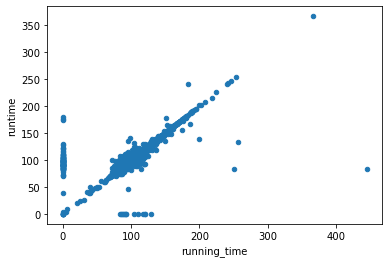

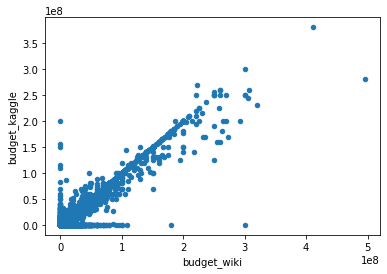

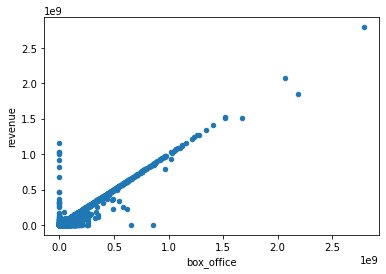

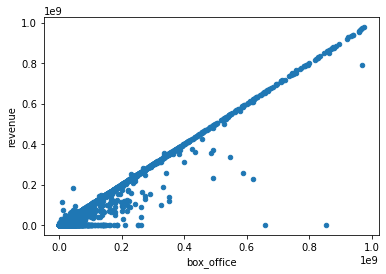

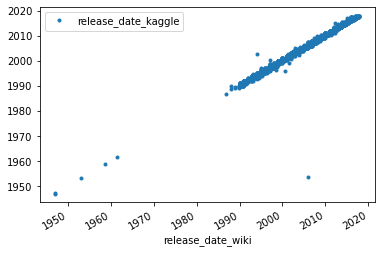

In [13]:
# 11. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load()

In [14]:
# 12. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
movies_with_ratings_df = kaggle_file
movies_df = ratings_file

In [15]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,...,Release date,Country,Language,Written by,Productioncompanies,imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990.0,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",...,"[July 11, 1990, (, 1990-07-11, )]",United States,English,NaN,NaN,tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990.0,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet",James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",...,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,English,NaN,NaN,tt0098994,2700000.0,6000000.0,1990-05-17,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990.0,https://www.imdb.com/title/tt0099005/,Air America,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",...,"[August 10, 1990, (, 1990-08-10, )]",United States,"[English, Lao]",NaN,NaN,tt0099005,57718089.0,35000000.0,1990-08-10,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990.0,https://www.imdb.com/title/tt0099012/,Alice,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",...,"[December 25, 1990, (, 1990-12-25, )]",United States,English,Woody Allen,NaN,tt0099012,7331647.0,12000000.0,1990-12-25,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990.0,https://www.imdb.com/title/tt0099018/,Almost an Angel,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",...,"December 19, 1990",US,English,Paul Hogan,NaN,tt0099018,6939946.0,25000000.0,1990-12-19,95.0


In [16]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,3.0,0.0,3.0,2.0,5.0,26.0,37.0,46.0,16.0,11.0


In [17]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,genres,original_language,overview,spoken_languages,country,production_companies,production_countries,starring,cinematography,based_on
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",en,"Ford ""Mr. Rock n' Roll Detective"" Fairlane is ...","[{'iso_639_1': 'en', 'name': 'English'}]",United States,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[Characters, by Rex Weiner]"
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",en,The intriguing relationship between three desp...,"[{'iso_639_1': 'en', 'name': 'English'}]",United States,"[{'name': 'Avenue Pictures Productions', 'id':...","[{'iso_3166_1': 'US', 'name': 'United States o...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[the novel, After Dark, My Sweet, by, Jim Thom..."
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,Air America was the CIA's private airline oper...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",United States,"[{'name': 'IndieProd Company Productions', 'id...","[{'iso_3166_1': 'US', 'name': 'United States o...","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[Air America, by, Christopher Robbins]"
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,"Alice Tate, mother of two, with a marriage of ...","[{'iso_639_1': 'en', 'name': 'English'}]",United States,"[{'name': 'Orion Pictures', 'id': 41}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,NaN
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,"[{'id': 14, 'name': 'Fantasy'}, {'id': 35, 'na...",en,Terry Dean is an electronics wizard and thief....,"[{'iso_639_1': 'en', 'name': 'English'}]",US,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,NaN
